In [13]:
from src.models import PlainNetwork, SkipNetwork, SqueezeExcitation
from sklearn.metrics import classification_report, confusion_matrix
from src.utils import ModelPerformanceExplorer
from tensorflow.data import TFRecordDataset
from matplotlib import pyplot as plt
from src.loader import DatasetBuilder
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
def perfom_casses(performance, event, samples=(2, 6), ratio=3):
    figsize = samples[1] * ratio, samples[0] * ratio
    fig, axis = plt.subplots(*samples, figsize=figsize)
    cases, mask = getattr(performance, event)()
    
    axis, tpl = axis.flatten(), 'P {} | T {}'
    x, y = performance.x[mask],  performance.y_pred[mask]
    actual, idx = performance.y[mask], performance.idx_to_label
    
    for i , case in enumerate(cases[:samples[0] * samples[1]]):
        axis[i].set_title(tpl.format(idx[y[case]], idx[actual[case]]))
        axis[i].imshow(x[case])
        axis[i].axis('off')
        
        
    fig.tight_layout()
    
def plot_confussion_matrix(y, y_pred, labels, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(y, y_pred, labels=labels, normalize='true')
    sns.heatmap(cm, cmap='seismic', yticklabels=labels, xticklabels=labels)

In [5]:
builder = DatasetBuilder('data', shape=(256, 256))

data_test = TFRecordDataset('data/test.records')
data_test = data_test.map(builder.decode)
data_test = data_test.batch(batch_size=32)

# VGG Results

In [144]:
model = PlainNetwork()
model.build((1, 256, 256, 3))
model.load_weights('models/vgg.h5')

In [146]:
predictions = model.predict(data_test, verbose=1)

125/125 [==============================] - 19s 153ms/step


In [147]:
performance = ModelPerformanceExplorer(predictions, data_test, 'data/mapping.txt')

125it [00:03, 34.44it/s]


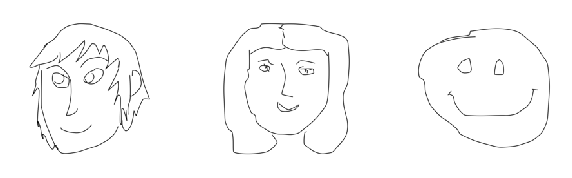

In [148]:
sample = performance.x[performance.y==146][3:10]
fig, axis = plt.subplots(1, 3, figsize=(10, 4))
for ax, i in zip(axis, [0, 4, 6]):
    ax.imshow(sample[i])
    ax.axis('off')

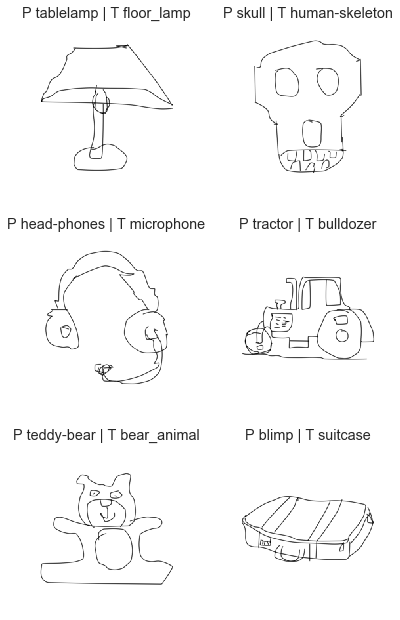

In [149]:
sns.set(font_scale=1.2)
perfom_casses(performance, 'wrong_cases', (3, 2))

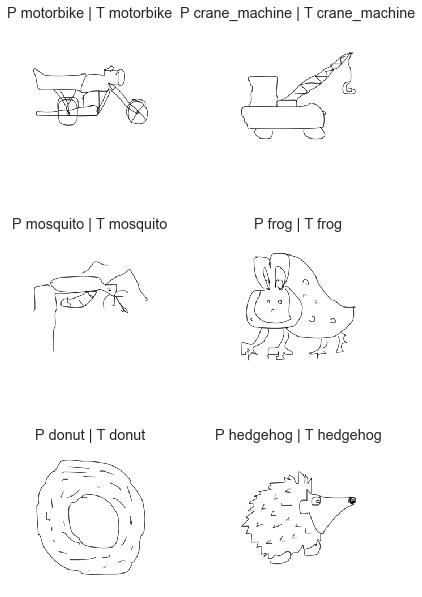

In [150]:
perfom_casses(performance, 'success_cases', (3, 2))

In [151]:
y_labels = [performance.idx_to_label[k] for k in performance.y]
y_pred_labels = [performance.idx_to_label[k] for k in performance.y_pred]
report = classification_report(y_labels, y_pred_labels, output_dict=True)

dataframe = pd.DataFrame(report).transpose()
dataframe = dataframe.sort_values(by='f1-score', ascending=False)

In [152]:
mask = dataframe.index.isin(['accuracy', 'macro avg', 'weighted avg'])
dataframe_global = dataframe[mask]
dataframe_global

,precision,recall,f1-score,support
accuracy,0.687750,0.687750,0.687750,0.68775
weighted avg,0.701486,0.687750,0.685281,4000.00000
macro avg,0.692364,0.689406,0.680922,4000.00000


In [153]:
dataframe = dataframe[~mask]

In [156]:
dataframe.head(10)

,precision,recall,f1-score,support
nose,1.000000,1.000000,1.000000,9.0
t-shirt,1.000000,1.000000,1.000000,20.0
wineglass,1.000000,0.947368,0.972973,19.0
trousers,1.000000,0.941176,0.969697,17.0
ladder,0.933333,1.000000,0.965517,14.0
giraffe,1.000000,0.904762,0.950000,21.0
umbrella,0.888889,1.000000,0.941176,16.0
eyeglasses,0.909091,0.952381,0.930233,21.0
grenade,1.000000,0.866667,0.928571,15.0
rainbow,0.866667,1.000000,0.928571,13.0


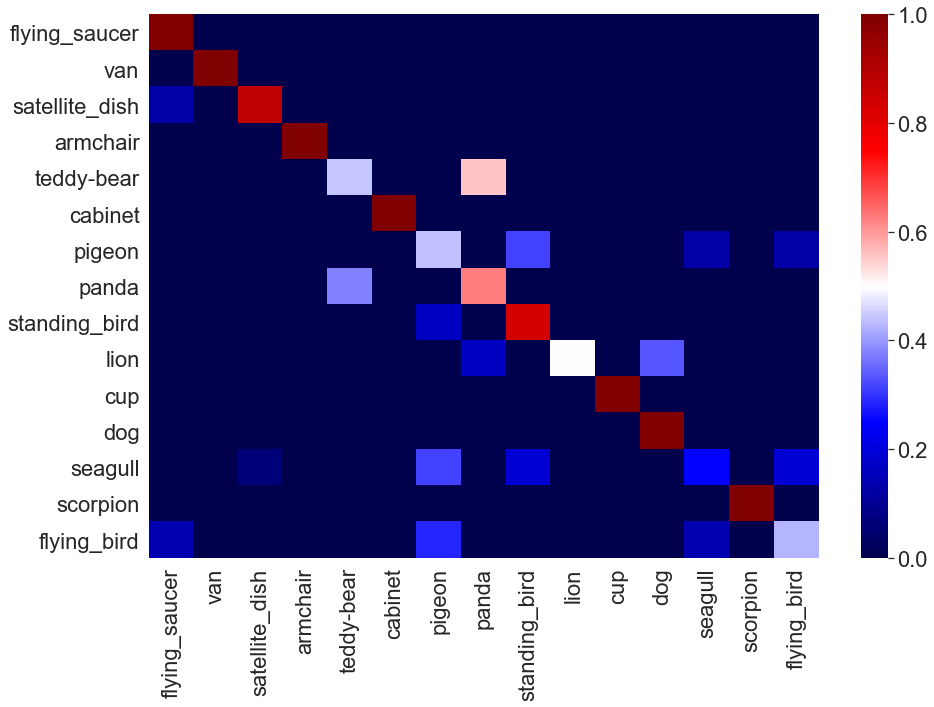

In [48]:
sns.set(font_scale=2.0)
plot_confussion_matrix(y_labels, y_pred_labels, dataframe.index[-15:])

# Resnet Case

In [49]:
model = SkipNetwork()
model.build((1, 256, 256, 3))
model.load_weights('models/renset.h5')

In [55]:
predictions = model.predict(data_test, verbose=1)
performance = ModelPerformanceExplorer(predictions, data_test, 'data/mapping.txt')
sns.set(font_scale=1.2)

125/125 [==============================] - 25s 197ms/step


125it [00:04, 25.20it/s]


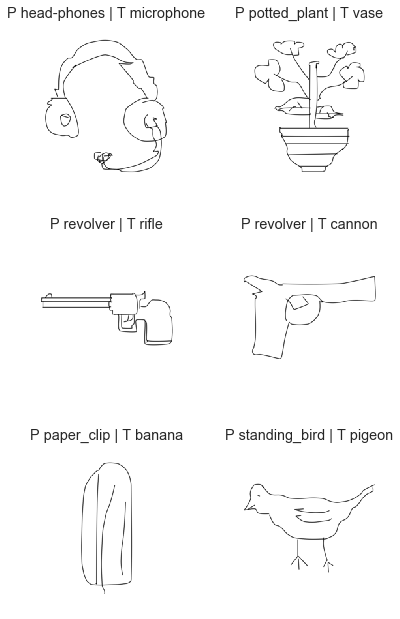

In [59]:
perfom_casses(performance, 'wrong_cases', (3, 2))

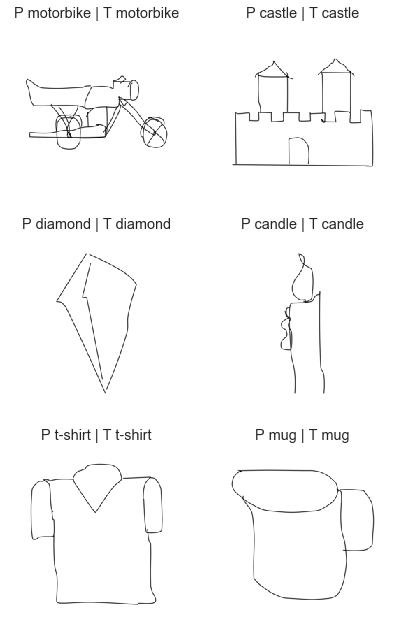

In [60]:
perfom_casses(performance, 'success_cases', (3, 2))

In [53]:
y_labels = [performance.idx_to_label[k] for k in performance.y]
y_pred_labels = [performance.idx_to_label[k] for k in performance.y_pred]
report = classification_report(y_labels, y_pred_labels, output_dict=True)

dataframe = pd.DataFrame(report).transpose()
dataframe = dataframe.sort_values(by='f1-score', ascending=False)
mask = dataframe.index.isin(['accuracy', 'macro avg', 'weighted avg'])
dataframe_global = dataframe[mask]
dataframe = dataframe[~mask]

dataframe_global

,precision,recall,f1-score,support
accuracy,0.66150,0.661500,0.661500,0.6615
weighted avg,0.67473,0.661500,0.658431,4000.0000
macro avg,0.66606,0.662907,0.654188,4000.0000


In [61]:
dataframe.head(10)

,precision,recall,f1-score,support
t-shirt,0.952381,1.000000,0.975610,20.0
wineglass,1.000000,0.947368,0.972973,19.0
trousers,1.000000,0.941176,0.969697,17.0
wine-bottle,0.900000,1.000000,0.947368,18.0
umbrella,0.888889,1.000000,0.941176,16.0
rainbow,0.866667,1.000000,0.928571,13.0
strawberry,0.928571,0.928571,0.928571,14.0
comb,1.000000,0.857143,0.923077,14.0
hourglass,0.916667,0.916667,0.916667,12.0
tennis-racket,0.842105,1.000000,0.914286,16.0


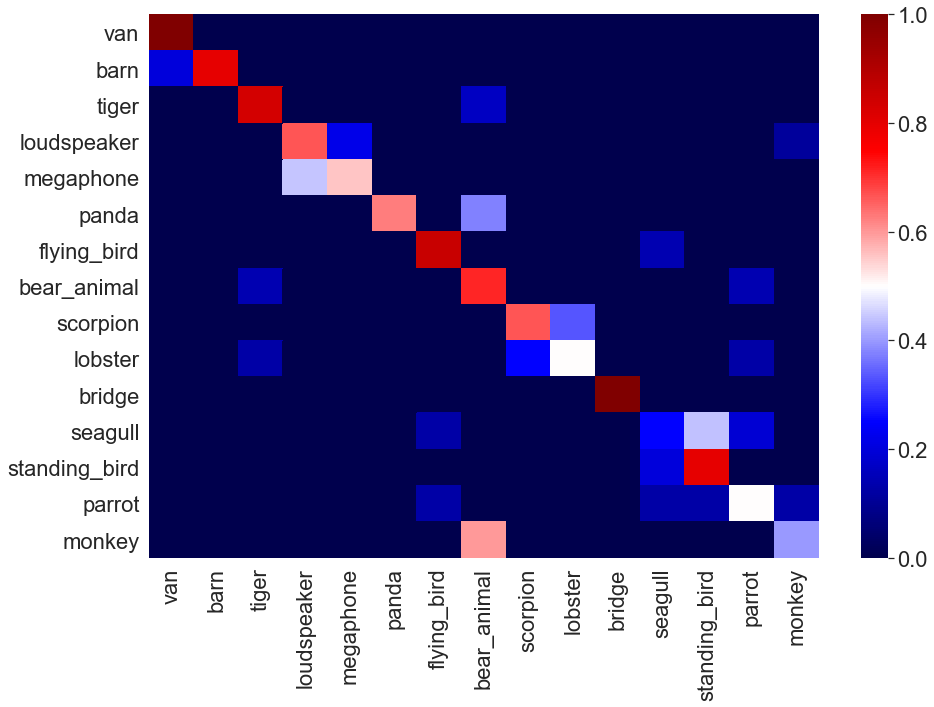

In [62]:
sns.set(font_scale=2.0)
plot_confussion_matrix(y_labels, y_pred_labels, dataframe.index[-15:])

# Squeeze Excitation Case

In [63]:
model = SqueezeExcitation()
model.build((1, 256, 256, 3))
model.load_weights('models/squeeze.h5')

In [65]:
predictions = model.predict(data_test, verbose=1)
performance = ModelPerformanceExplorer(predictions, data_test, 'data/mapping.txt')
sns.set(font_scale=1.2)

125/125 [==============================] - 27s 212ms/step


125it [00:04, 27.34it/s]


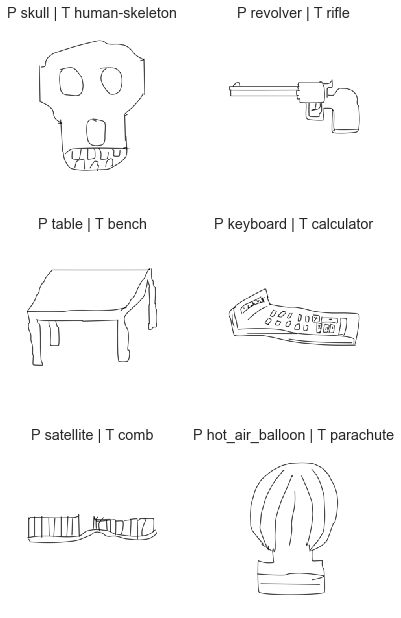

In [66]:
perfom_casses(performance, 'wrong_cases', (3, 2))

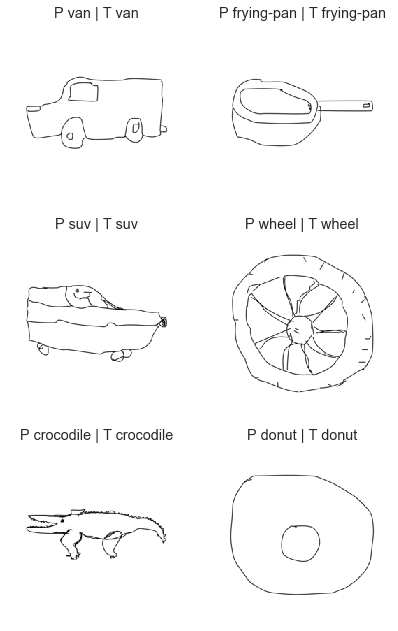

In [67]:
perfom_casses(performance, 'success_cases', (3, 2))

In [68]:
y_labels = [performance.idx_to_label[k] for k in performance.y]
y_pred_labels = [performance.idx_to_label[k] for k in performance.y_pred]
report = classification_report(y_labels, y_pred_labels, output_dict=True)

dataframe = pd.DataFrame(report).transpose()
dataframe = dataframe.sort_values(by='f1-score', ascending=False)
mask = dataframe.index.isin(['accuracy', 'macro avg', 'weighted avg'])
dataframe_global = dataframe[mask]
dataframe = dataframe[~mask]

dataframe_global

,precision,recall,f1-score,support
accuracy,0.631000,0.631000,0.631000,0.631
weighted avg,0.649772,0.631000,0.629364,4000.000
macro avg,0.636031,0.633234,0.623046,4000.000


In [69]:
dataframe.head(10)

,precision,recall,f1-score,support
t-shirt,0.952381,1.000000,0.975610,20.0
harp,0.947368,1.000000,0.972973,18.0
snail,0.941176,1.000000,0.969697,16.0
wine-bottle,0.900000,1.000000,0.947368,18.0
trousers,0.941176,0.941176,0.941176,17.0
comb,1.000000,0.857143,0.923077,14.0
snowman,0.941176,0.888889,0.914286,18.0
sponge_bob,0.875000,0.933333,0.903226,15.0
nose,0.818182,1.000000,0.900000,9.0
sun,0.947368,0.857143,0.900000,21.0


In [77]:
print(dataframe.head(10).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &  support \\
\midrule
t-shirt     &   0.952381 &  1.000000 &  0.975610 &     20.0 \\
harp        &   0.947368 &  1.000000 &  0.972973 &     18.0 \\
snail       &   0.941176 &  1.000000 &  0.969697 &     16.0 \\
wine-bottle &   0.900000 &  1.000000 &  0.947368 &     18.0 \\
trousers    &   0.941176 &  0.941176 &  0.941176 &     17.0 \\
comb        &   1.000000 &  0.857143 &  0.923077 &     14.0 \\
snowman     &   0.941176 &  0.888889 &  0.914286 &     18.0 \\
sponge\_bob  &   0.875000 &  0.933333 &  0.903226 &     15.0 \\
nose        &   0.818182 &  1.000000 &  0.900000 &      9.0 \\
sun         &   0.947368 &  0.857143 &  0.900000 &     21.0 \\
\bottomrule
\end{tabular}



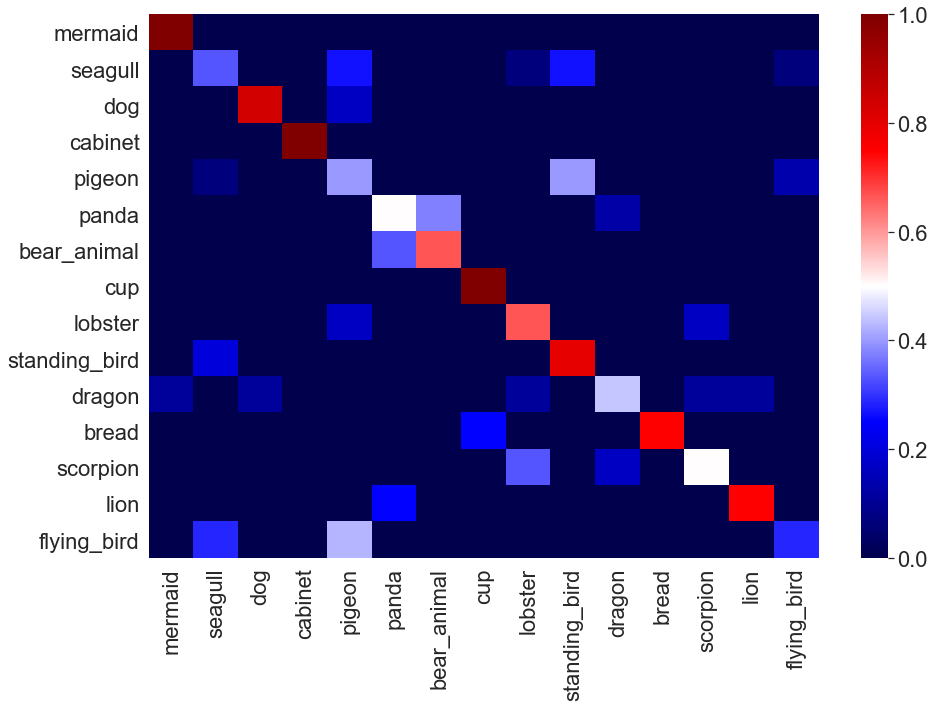

In [74]:
sns.set(font_scale=2.0)
plot_confussion_matrix(y_labels, y_pred_labels, dataframe.index[-15:])

In [183]:
results = pd.DataFrame(dict(Basic=[0.688, 0.681],
                            ResNet=[0.662, 0.654], 
                            Squeeze=[0.631, 0.623]), index=['accuracy', 'f1-score'])

print(results.T.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  accuracy &  f1-score \\
\midrule
Basic   &     0.688 &     0.681 \\
ResNet  &     0.662 &     0.654 \\
Squeeze &     0.631 &     0.623 \\
\bottomrule
\end{tabular}



In [189]:
import tensorflow as tf

def generate_graph(model, logdir):
    
    @tf.function()
    def optimized_model(x):
        return model(x)
    
    name = model.__class__.__name__
    writer = tf.summary.create_file_writer(logdir)
    x = tf.random.uniform((1, 256, 256,3))
    tf.summary.trace_on(graph=True, profiler=True)
    z = optimized_model(x)
    
    with writer.as_default():
        tf.summary.trace_export(name=name, step=0, profiler_outdir=logdir)